In [24]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import medfilt
import pywt
from ecgdetectors import Detectors

In [25]:
scd_data = {'./data/scddb/30': '07:54:33',
 './data/scddb/31': '13:42:24',
 './data/scddb/32': '16:45:18',
 './data/scddb/33': '04:46:19',
 './data/scddb/34': '06:35:44',
 './data/scddb/35': '24:34:56',
 './data/scddb/36': '18:59:01',
 './data/scddb/37': '01:31:13',
 './data/scddb/38': '08:01:54',
 './data/scddb/39': '04:37:51',
 './data/scddb/41': '02:59:24',
 './data/scddb/43': '15:37:11',
 './data/scddb/44': '19:38:45',
 './data/scddb/45': '18:09:17',
 './data/scddb/46': '03:41:47',
 './data/scddb/47': '06:13:01',
 './data/scddb/48': '02:29:40',
 './data/scddb/50': '11:45:43',
 './data/scddb/51': '22:58:23',
 './data/scddb/52': '02:32:40'}


fs = 250

In [3]:
def hms_to_seconds(hms):
    h, m, s = hms.split(':')
    return int(h)*3600 + int(m)*60 + int(s)

In [4]:
def extract_before_onset_VF(vfon_dict, minutes_before=30):
    ecg_data_map = {} 

    for record_path, vf_onset_str in vfon_dict.items():
        # record_path might be '.data/scddb/30'
        record_dir, record_name = os.path.split(record_path)

        # 2) Convert dictionary's VF onset to seconds
        vf_onset_original_sec = hms_to_seconds(vf_onset_str)

        vfon_onset_original_sample = vf_onset_original_sec * fs

        seg_len_samples = int(minutes_before * 60 * fs)

        start_sample = vfon_onset_original_sample - seg_len_samples

         # read .dat between those sample indices
        try:
            #record_dat_path = os.path.join(record_dir, record_name)  # base path
            record_path_dat = os.path.join(record_dir, record_name)
            segment = wfdb.rdrecord(record_path_dat, sampfrom=start_sample, sampto=vfon_onset_original_sample)
            
        except Exception as e:
            print(f"[ERROR] Failed to read record {record_dat_path}: {e}")
            continue

        # Retrieve the raw signal data as a NumPy array
        if segment.p_signal is not None:
            arr = segment.p_signal[:,0]
            ecg_data_map[record_name] = arr
            print(f"[OK] Extracted 30-min for {record_name}: shape={arr.shape}")
        else:
            print(f"[WARNING] No p_signal found for {record_name}")

    return ecg_data_map

In [5]:
x = extract_before_onset_VF(scd_data, minutes_before=30)

[OK] Extracted 30-min for 30: shape=(450000,)
[OK] Extracted 30-min for 31: shape=(450000,)
[OK] Extracted 30-min for 32: shape=(450000,)
[OK] Extracted 30-min for 33: shape=(450000,)
[OK] Extracted 30-min for 34: shape=(450000,)
[OK] Extracted 30-min for 35: shape=(450000,)
[OK] Extracted 30-min for 36: shape=(450000,)
[OK] Extracted 30-min for 37: shape=(450000,)
[OK] Extracted 30-min for 38: shape=(450000,)
[OK] Extracted 30-min for 39: shape=(450000,)
[OK] Extracted 30-min for 41: shape=(450000,)
[OK] Extracted 30-min for 43: shape=(450000,)
[OK] Extracted 30-min for 44: shape=(450000,)
[OK] Extracted 30-min for 45: shape=(450000,)
[OK] Extracted 30-min for 46: shape=(450000,)
[OK] Extracted 30-min for 47: shape=(450000,)
[OK] Extracted 30-min for 48: shape=(450000,)
[OK] Extracted 30-min for 50: shape=(450000,)
[OK] Extracted 30-min for 51: shape=(450000,)
[OK] Extracted 30-min for 52: shape=(450000,)


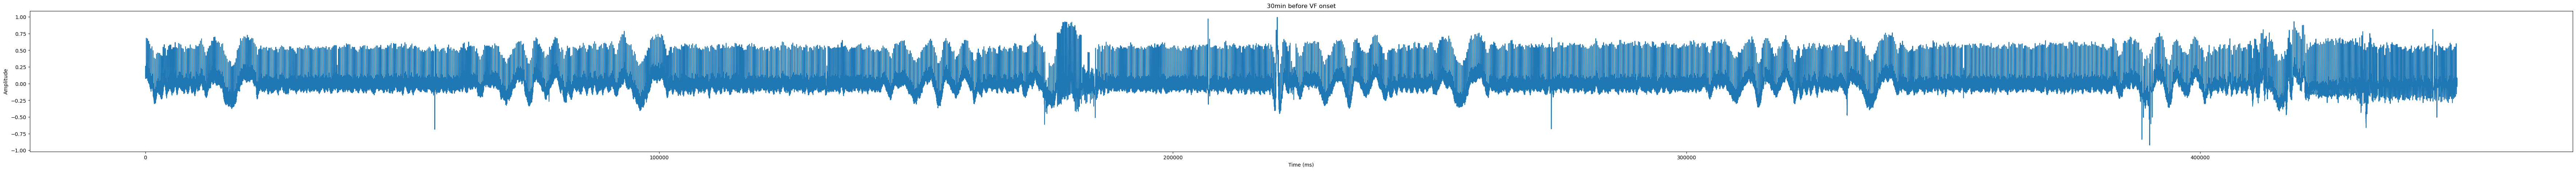

In [6]:
plt.figure(figsize=(90, 5))
plt.subplot()
plt.plot(x['30'])
plt.title('30min before VF onset')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()

# Baseline wander

In [7]:
def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res

In [8]:
ms_flt_array = [0.2,0.6]    #<-- length of baseline fitting filters (in seconds)
mfa = np.zeros(len(ms_flt_array), dtype='int')
for i in range(0, len(ms_flt_array)):
    mfa[i] = get_median_filter_width(fs,ms_flt_array[i])

In [9]:
mfa

array([ 49, 149])

In [10]:
def filter_signal(X):
    global mfa
    X0 = X  #read orignal signal
    for mi in range(0,len(mfa)):
        X0 = medfilt(X0,mfa[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0

In [13]:
baselinewander30 = filter_signal(x['30'])
print(x['30'].shape, baselinewander30.shape)

(450000,) (450000,)


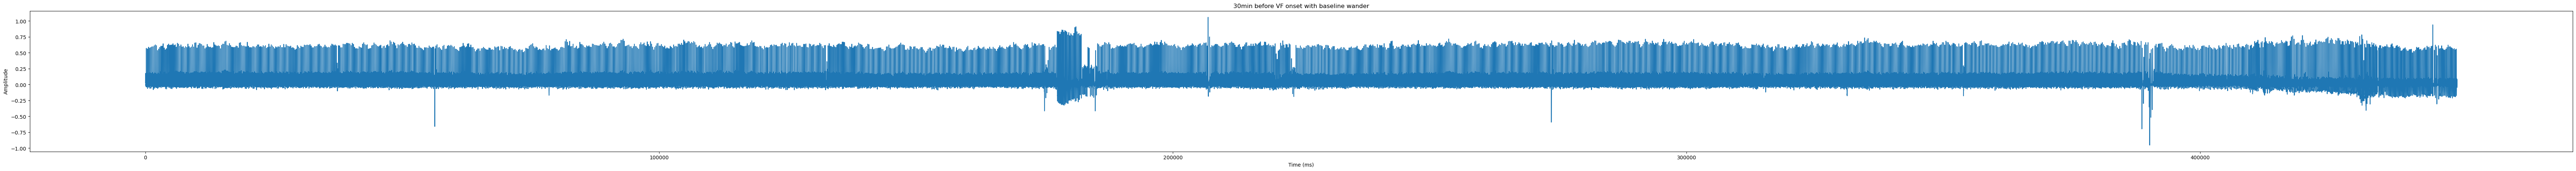

In [14]:
plt.figure(figsize=(90, 5))
plt.subplot()
plt.plot(baselinewander30)
plt.title('30min before VF onset with baseline wander')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()

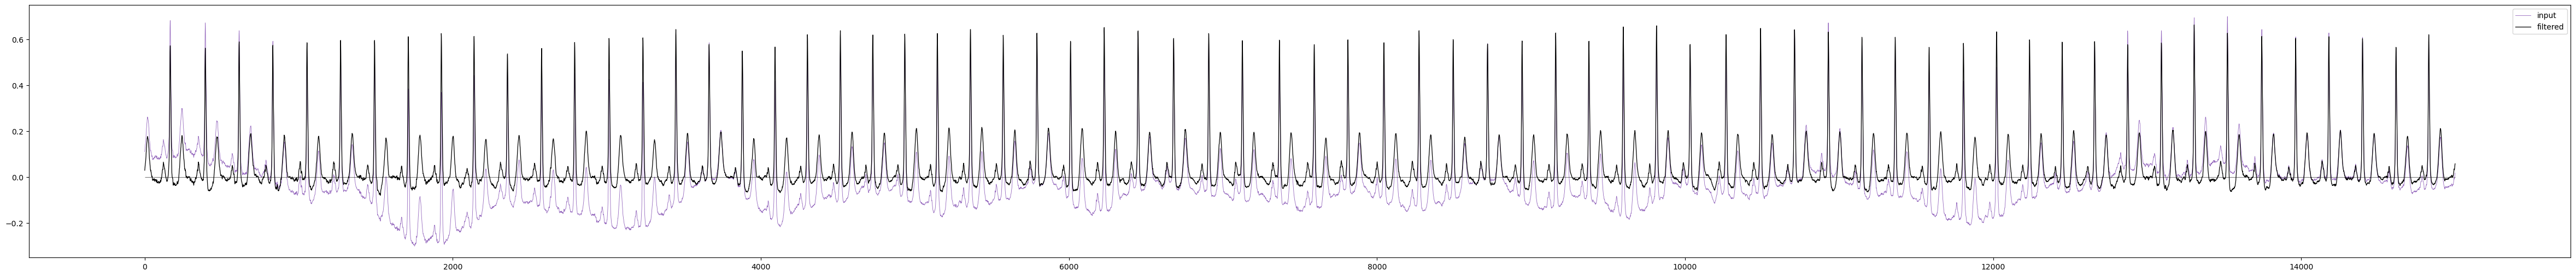

In [17]:
plt.figure(figsize=(60,6))

plt.plot(x['30'][:15000], color='tab:purple', linewidth=0.6,label = 'input')
plt.plot(baselinewander30[:15000], color='black', linewidth=0.9,label = 'filtered')
plt.hlines(0,0,15000,color='black', linewidth=0.4)
plt.legend()
plt.show()

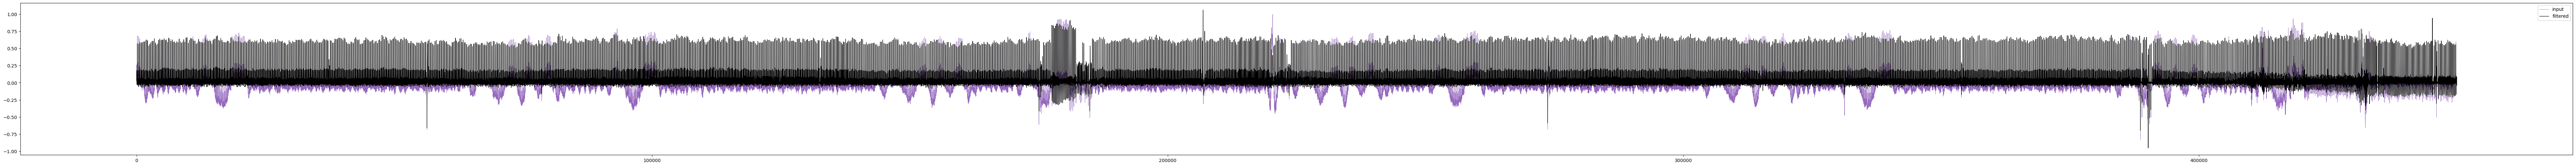

In [18]:
plt.figure(figsize=(100,6))

plt.plot(x['30'], color='tab:purple', linewidth=0.6,label = 'input')
plt.plot(baselinewander30, color='black', linewidth=0.9,label = 'filtered')
plt.hlines(0,0,450000,color='black', linewidth=0.4)
plt.legend()
plt.show()

# Denoise

In [21]:
def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = pywt.wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y  

In [26]:
sig_denoised30_1 = denoise_signal(x['30'],'bior4.4', 9 , 1 , 7)

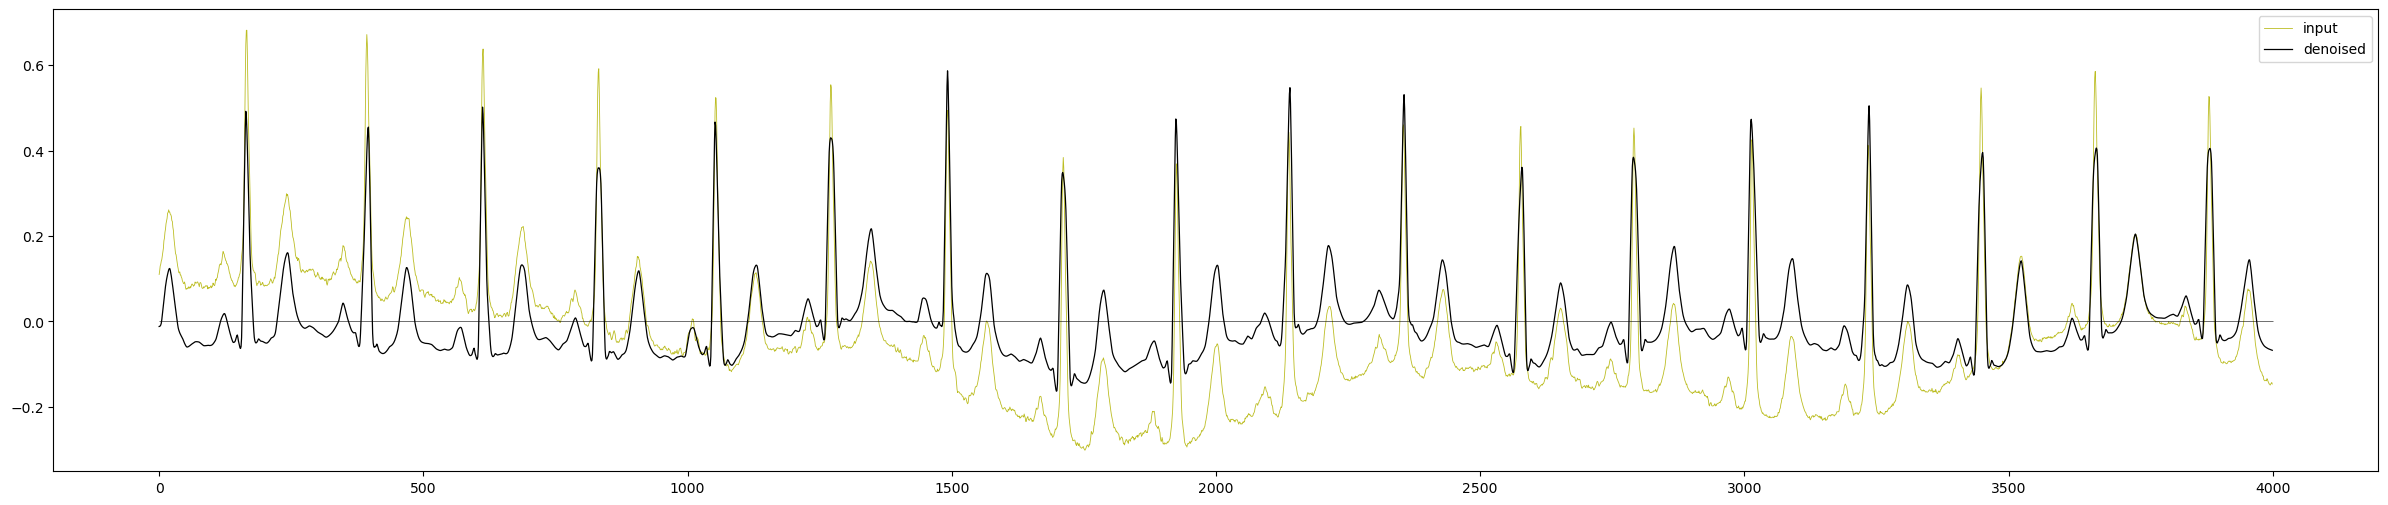

In [27]:
plt.figure(figsize=(30,6))

plt.plot(x['30'][0:4000], color='tab:olive', linewidth=0.6,label = 'input')
plt.plot(sig_denoised30_1[0:4000], color='black', linewidth=0.9,label = 'denoised')
plt.hlines(0,0,4000,color='black', linewidth=0.4)
plt.legend()
plt.show()

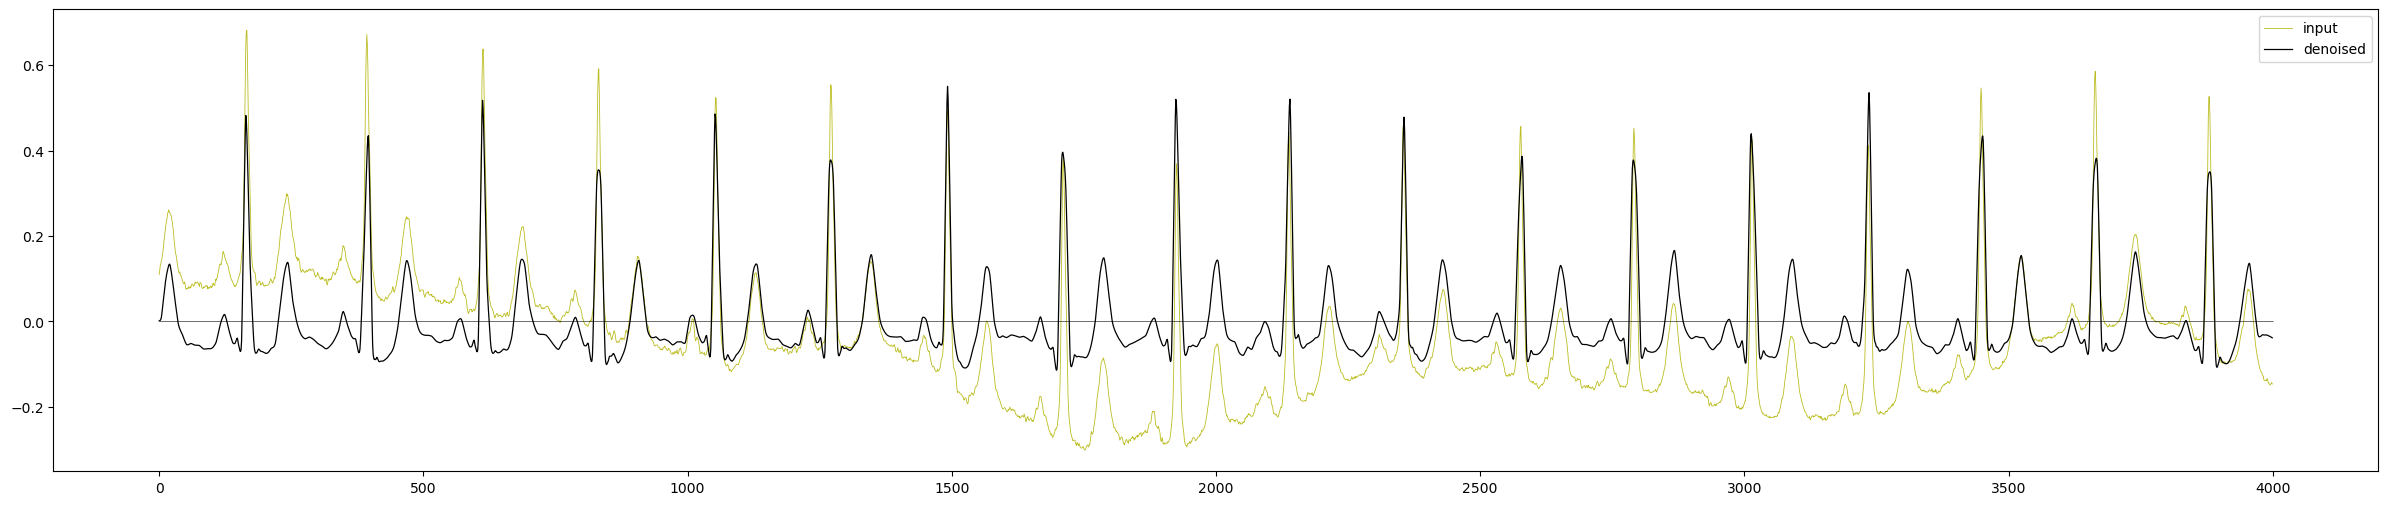

In [28]:
sig_denoised30_1 = denoise_signal(baselinewander30,'bior4.4', 9 , 1 , 7)

plt.figure(figsize=(30,6))

plt.plot(x['30'][0:4000], color='tab:olive', linewidth=0.6,label = 'input')
plt.plot(sig_denoised30_1[0:4000], color='black', linewidth=0.9,label = 'denoised')
plt.hlines(0,0,4000,color='black', linewidth=0.4)
plt.legend()
plt.show()

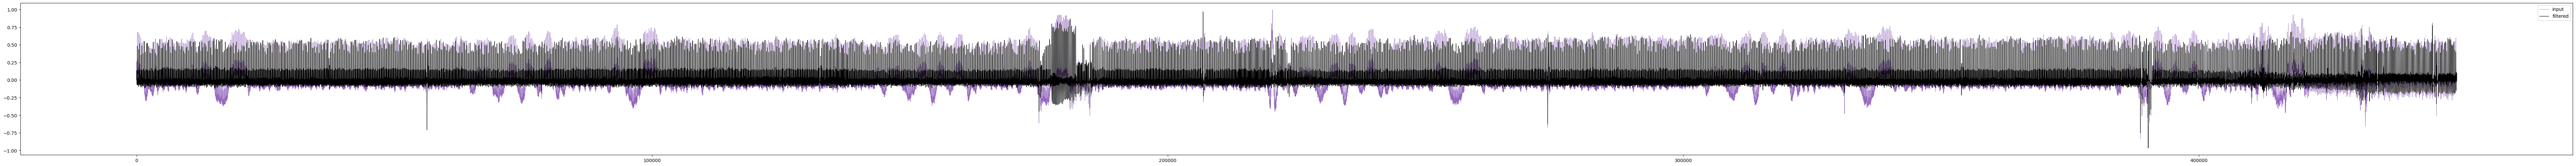

In [29]:
plt.figure(figsize=(100,6))

plt.plot(x['30'], color='tab:purple', linewidth=0.6,label = 'input')
plt.plot(sig_denoised30_1, color='black', linewidth=0.9,label = 'filtered')
plt.hlines(0,0,450000,color='black', linewidth=0.4)
plt.legend()
plt.show()

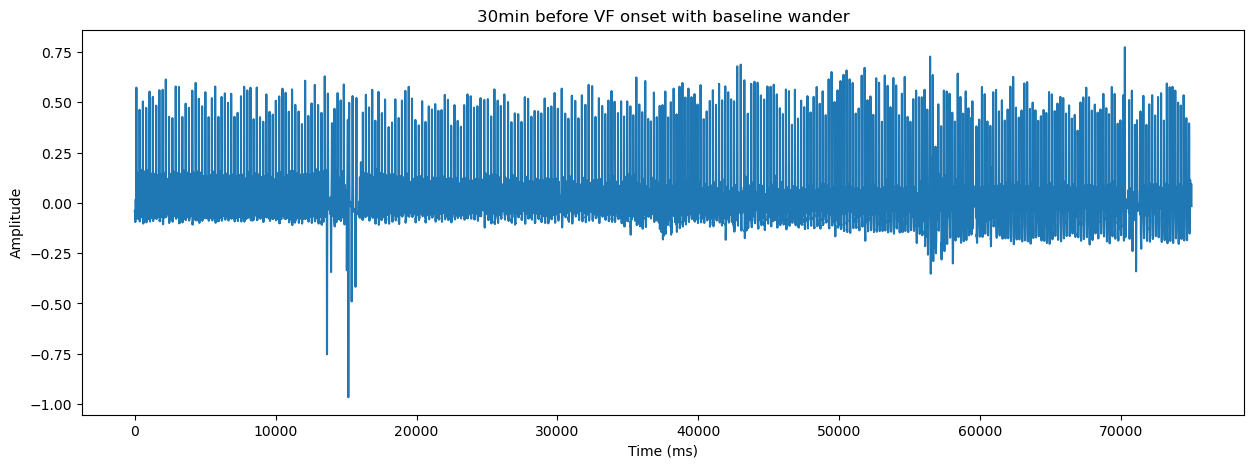

In [34]:
plt.figure(figsize=(15, 5))
plt.subplot()
plt.plot(sig_denoised30_1[-75000:])
plt.title('30min before VF onset with baseline wander')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()

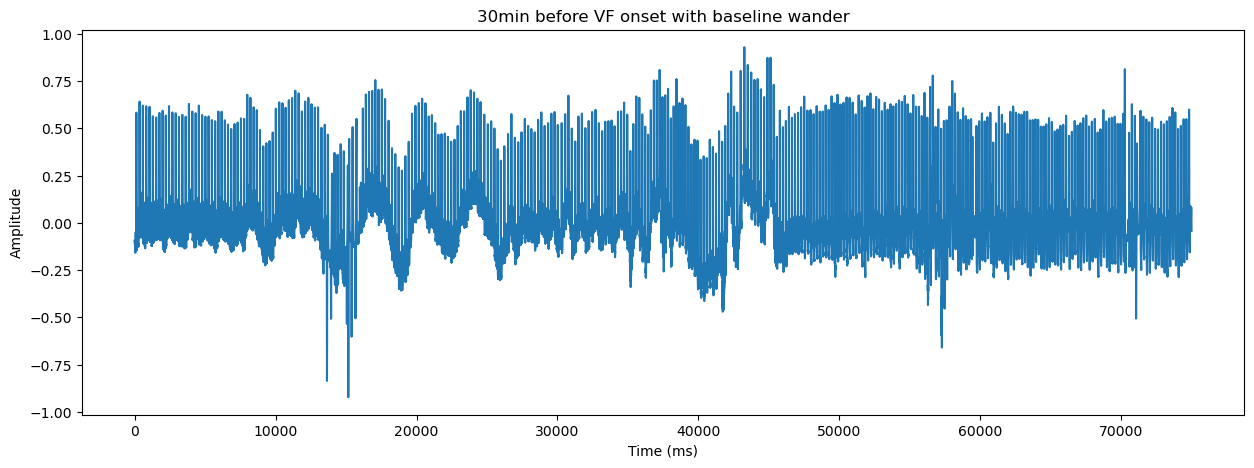

In [35]:
plt.figure(figsize=(15, 5))
plt.subplot()
plt.plot(x['30'][-75000:])
plt.title('30min before VF onset with baseline wander')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()

#Now first is denoise and bw

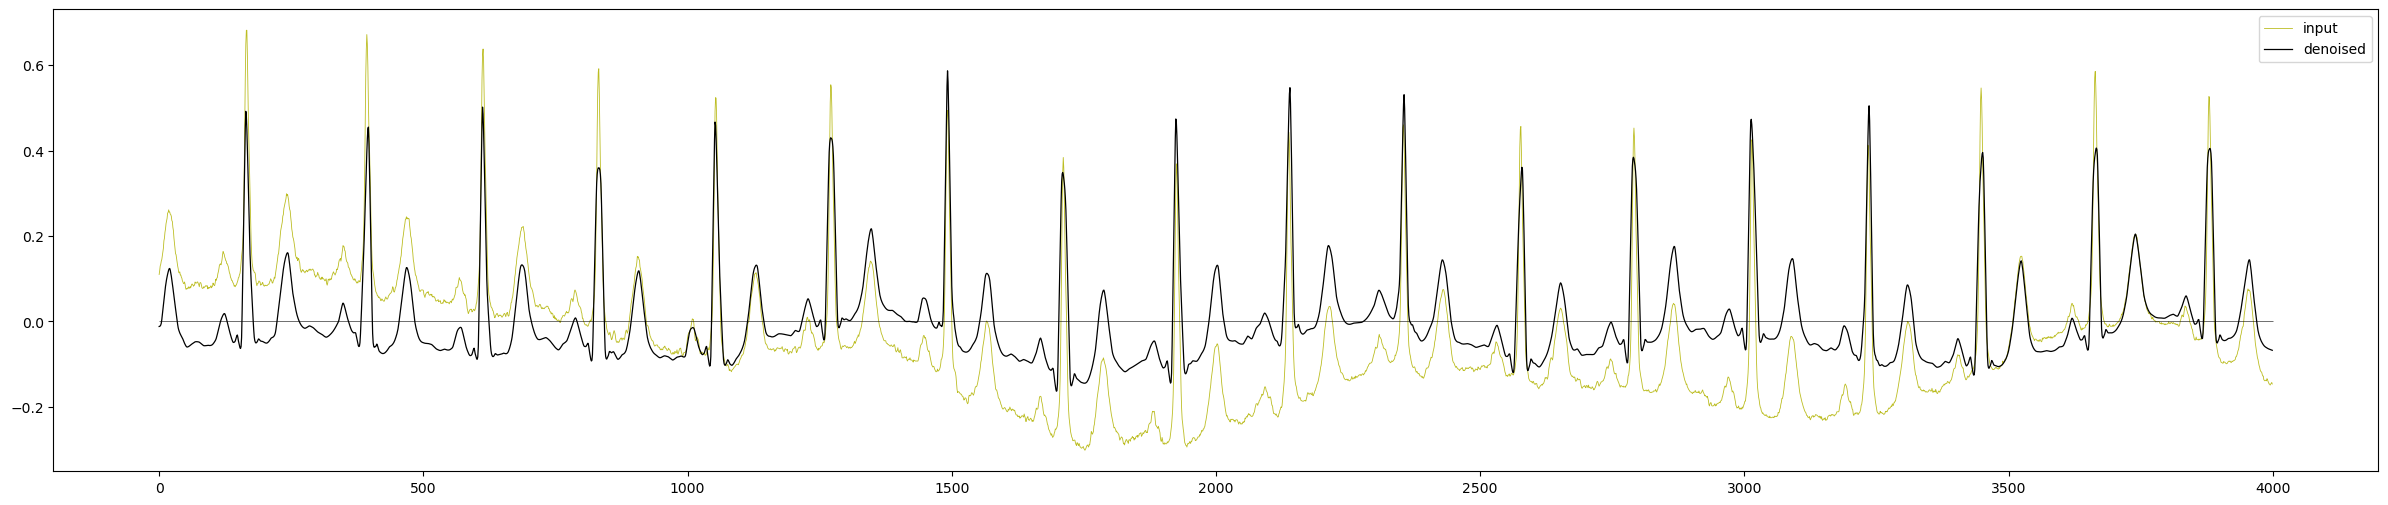

In [36]:
sig_denoised30_2 = denoise_signal(x['30'],'bior4.4', 9 , 1 , 7)

plt.figure(figsize=(30,6))

plt.plot(x['30'][0:4000], color='tab:olive', linewidth=0.6,label = 'input')
plt.plot(sig_denoised30_2[0:4000], color='black', linewidth=0.9,label = 'denoised')
plt.hlines(0,0,4000,color='black', linewidth=0.4)
plt.legend()
plt.show()

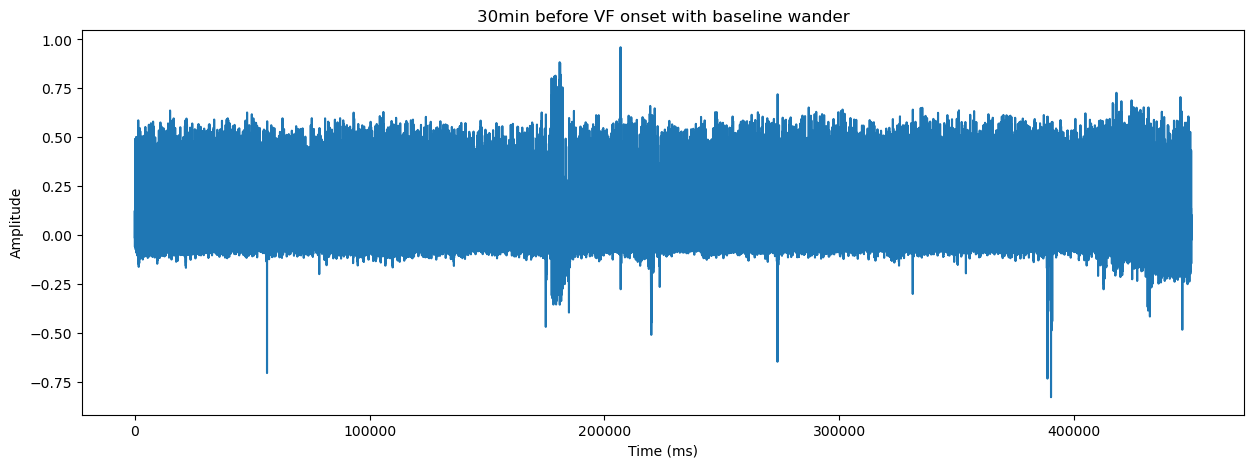

In [38]:
plt.figure(figsize=(15, 5))
plt.subplot()
plt.plot(sig_denoised30_2)[-75000:]
plt.title('30min before VF onset with baseline wander')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()